##I am splitting v3_Clean_model_add_Pis_feat.ipynb into 2 notebooks 

-this one on modelling and 

-another one on creating stats data set (just Pisch for now)
v1_stats_tools_Pish.ipynb

In [1]:
##part 1
##use models with default
##use data set with H/A +1, -1
##do full window for now

##next:
##check if just excluding first 10 days helps (chaotic)
##check if different windows help

##next
## can try tuning (for loops by hand, or ... use grid_search (use ML mastery code))
##-I think tuning will be faster ... just do by hand ... loop over the possible things 
##-ONE for loop over i = (a,b,c,d)... for each model i[0]

##Orrr can try adding features ... here we have to worry about:
##-adding basic features eg pp, and correct fo%
##-scaling numericals
##-dummy vars for categoricals (are there any?) besides H/A
##-num_windows and which lengths for moving avgs
##-filtering the features for increasing complexity inteligently
##-There is a dicotemy: 
##(a)use H/A + numerics or  ... here I think it can be made more like time-series
##(b) just use mumerics (moving avg) ... here I think the order of the games is not important (note Leung did this, and random train)



In [2]:
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, f1_score


import matplotlib.pyplot as plt
import seaborn as sns


##couple evaluation functions ##removed model_name as variable
def evaluate_binary_classification(y_test, y_pred, y_proba=None, graph = False):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    #try:
    if y_proba != None:
        rocauc_score = roc_auc_score(y_test, y_proba)
    else:
        rocauc_score = "no roc"
    #except: 
    #    pass     
    cm = confusion_matrix(y_test, y_pred)
    if graph == True:
        sns.heatmap(cm, annot=True)
        plt.tight_layout()
        plt.title(f'{model_name}', y=1.1)
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        plt.show()
    print("accuracy: ", accuracy)
    print("precision: ", precision)
    print("recall: ", recall)
    print("f1 score: ", f1)
    print("rocauc: ", rocauc_score)
    print(cm)
    #return accuracy, precision, recall, f1, rocauc_score

def evaluate_regression(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print("mae", mae)
    print("mse", mse)
    print('r2', r2)
    
##display null values


def perc_null(X):
    
    total = X.isnull().sum().sort_values(ascending=False)
    data_types = X.dtypes
    percent = (X.isnull().sum()/X.isnull().count()).sort_values(ascending=False)

    missing_data = pd.concat([total, data_types, percent], axis=1, keys=['Total','Type' ,'Percent'])
    return missing_data


In [3]:
def regr_model_results(model, model_name, X, dates, step, window_size, prediction_size, drop_first_k_days = 0): #X = data 
    results_dic['model_name'] = []
    results_dic['date'] = []
    results_dic['mae'] = []
    results_dic['mse'] = []
    results_dic['r2'] = []   
    
    
    #drop first k days from dates and X
    dates = dates[drop_first_k_days :]
    X = X.loc[X['full_date'].isin(dates), :].copy()  

    for i in range(step, len(dates), step): ##eg step =10, so 17 rounds
        
        model.fit(X.loc[X['full_date'].isin(dates[max(i-window_size ,0):i]), :],y.loc[y['full_date'].isin(dates[max(i-window_size,0):i]),'goal_difference' ])
        y_pred = model.predict(X.loc[X['full_date'].isin(dates[i:i+prediction_size]), :])
        y_test = y.loc[y['full_date'].isin(dates[i:i+prediction_size]),'goal_difference' ]
        
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        results_dic['model_name'].append(model_name)
        results_dic['date'].append(dates[i])
    
        results_dic['mae'].append(mae)
        results_dic['mse'].append(mse)
        results_dic['r2'].append(r2)
        
    return results_dic #!
        
        

In [4]:
def class_model_results(model, model_name, X, dates, step, window_size, prediction_size, drop_first_k_days = 0): #X = data 
    results_dic ={}
    results_dic['model_name'] = []
    results_dic['date'] = []
    results_dic['accuracy'] = []
    results_dic['f1_score'] = []

    #results_dic['precision'] = []
  #  results_dic['recall'] = []
    
    #drop first k days from dates and X
    dates = dates[drop_first_k_days :]
    X = X.loc[X['full_date'].isin(dates), :].copy()  

    for i in range(step, len(dates), step): ##eg step =10, so 17 rounds
        model.fit(X.loc[X['full_date'].isin(dates[max(i-window_size ,0):i]), :],y.loc[y['full_date'].isin(dates[max(i-window_size,0):i]),'won' ])
        y_pred = model.predict(X.loc[X['full_date'].isin(dates[i:i+prediction_size]), :])
        y_test = y.loc[y['full_date'].isin(dates[i:i+prediction_size]),'won' ]
    
        accuracy = accuracy_score(y_test, y_pred)
        #recision = precision_score(y_test, y_pred, zero_division = 0)
        #recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred) #, average = None)
            
        results_dic['model_name'].append(model_name)  #append same model name every iter so same length as others
        results_dic['date'].append(dates[i])
                          
        results_dic['accuracy'].append(accuracy)
        results_dic['f1_score'].append(f1)
        #results_dic['precision'].append(precision)
        #results_dic['recall'].append(recall)
    results_dic['model_name'].append('model_name'+'_avg')  #append same model name every iter so same length as others
    results_dic['date'].append('average')
    results_dic['accuracy'].append(round(np.mean(np.array(results_dic['accuracy'])), 2) ) 
    results_dic['f1_score'].append(round(np.mean(np.array(results_dic['f1_score'])), 2) ) 
    return results_dic #!
        
        

In [5]:
##note KNN or other clusters might be helpful group the teams in smart way ... but not now.
#models

##regression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

#classifiers (non-tree)
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


#tree-based classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from xgboost import XGBRegressor

##regression models
lr = Ridge(alpha=0.001) 
rfr = RandomForestRegressor(max_depth=3, random_state=0)
xgbr = XGBRegressor()

##classifier models
lrc = RidgeClassifier()
gnb = GaussianNB()
lgr = LogisticRegression(random_state = 0)
svc = SVC()

#tree-based classifiers
rfc =  RandomForestClassifier(max_depth=3, random_state=0)
bc = BaggingClassifier()
gbc = GradientBoostingClassifier()
xgbc = XGBClassifier()


##TUNING INFO 


##hyper_parameters from here 
##https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
##for xgboost from here 
##https://machinelearningmastery.com/extreme-gradient-boosting-ensemble-in-python/

#xgb

trees = [10, 50, 100, 500, 1000, 5000]  #100  #num of trees
max_depth = range(1,11)  ##3-5
rates = [0.0001, 0.001, 0.01, 0.1, 1.0]  #0.1
subsample in arange(0.1, 1.1, 0.1):  #0.4, 0.5  ##this is 0.1, 0.2 ... 1.0 # % of features to sample


#svc 
kernels in [‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’] #if you use poly, then adjust degree
C in [100, 10, 1.0, 0.1, 0.001]

#gb

learning_rate in [0.001, 0.01, 0.1]
n_estimators [10, 100, 1000]
subsample in [0.5, 0.7, 1.0]
max_depth in [3, 7, 9]


#rfc
max_features [1 to 20]  #key
max_features in [‘sqrt’, ‘log2’]
n_estimators in [10, 100, 1000]

#bc
n_estimators in [10, 100, 1000]

svm_dic = {'kernels':[‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’]}
lrc_dic = {'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
lgr_hp_dic = {'solver': [‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’], 'penalty' : [‘none’, ‘l1’, ‘l2’, ‘elasticnet’],
'C' :[100, 10, 1.0, 0.1, 0.01]}

In [7]:

##classifier models
lrc = RidgeClassifier()
gnb = GaussianNB()
lgr = LogisticRegression(random_state = 0)
svc = SVC(kernel = 'rbf')

#tree-based classifiers
rfc =  RandomForestClassifier(max_depth=5, random_state=0)
bc = BaggingClassifier()
gbc = GradientBoostingClassifier()
xgbc = XGBClassifier()


In [9]:
data = pd.read_csv('/Users/joejohns/data_bootcamp/GitHub/final_project_nhl_prediction/Note_books/Explore_Models/data_dummies_Pis_v2.csv')

In [18]:
data.rename(columns ={'win%':'win%_cumul'}, inplace = True)


In [30]:
data.columns

Index(['Unnamed: 0', 'won', 'goal_difference', 'Open', 'game_id', 'full_date',
       'date', 'ANA', 'ARI', 'BOS', 'BUF', 'CAR', 'CBJ', 'CGY', 'CHI', 'COL',
       'DAL', 'DET', 'EDM', 'FLA', 'LAK', 'MIN', 'MTL', 'NJD', 'NSH', 'NYI',
       'NYR', 'OTT', 'PHI', 'PIT', 'SJS', 'STL', 'TBL', 'TOR', 'VAN', 'WPG',
       'WSH', 'goalsAgainst_cumul_sum', 'goalsFor_cumul_sum',
       'goalsDiff_cumul_sum', 'goalsFor%_cumul_avg', 'pp%_cumul_avg',
       'pk%_cumul_avg', 'sh%_cumul_avg', 'sv%_cumul_avg', 'PDO_cumul_avg',
       'fenwickPercentage_cumul_avg', 'last_10_games_win%', 'win%_cumul'],
      dtype='object')

In [19]:

data.iloc[:10,7:].columns   ##columns are all safe ... 
#win%_cumul HAS to be previous day (NOT including day of ... o/w model can inspect 
#which teams win% went up and which ... actually kinda tough bec it's difference )
##anyway I checked in v1_stats 'SJS' ... that win% = win%_cumul is *strictly* the previous days

Index(['ANA', 'ARI', 'BOS', 'BUF', 'CAR', 'CBJ', 'CGY', 'CHI', 'COL', 'DAL',
       'DET', 'EDM', 'FLA', 'LAK', 'MIN', 'MTL', 'NJD', 'NSH', 'NYI', 'NYR',
       'OTT', 'PHI', 'PIT', 'SJS', 'STL', 'TBL', 'TOR', 'VAN', 'WPG', 'WSH',
       'goalsAgainst_cumul_sum', 'goalsFor_cumul_sum', 'goalsDiff_cumul_sum',
       'goalsFor%_cumul_avg', 'pp%_cumul_avg', 'pk%_cumul_avg',
       'sh%_cumul_avg', 'sv%_cumul_avg', 'PDO_cumul_avg',
       'fenwickPercentage_cumul_avg', 'last_10_games_win%', 'win%_cumul'],
      dtype='object')

In [34]:
data.iloc[10:30, :]

,Unnamed: 0,won,goal_difference,Open,game_id,full_date,date,ANA,ARI,BOS,...,goalsDiff_cumul_sum,goalsFor%_cumul_avg,pp%_cumul_avg,pk%_cumul_avg,sh%_cumul_avg,sv%_cumul_avg,PDO_cumul_avg,fenwickPercentage_cumul_avg,last_10_games_win%,win%_cumul
10,10,1,1.0,-125,2012020011,20130119,119,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,11,1,2.0,-130,2012020012,20130119,119,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,12,0,-4.0,-175,2012020013,20130119,119,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,13,1,3.0,-115,2012020014,20130120,120,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,14,0,-3.0,-115,2012020015,20130120,120,0,0,0,...,-4.0,-0.500000,-0.666667,0.000000,-0.063492,-0.051198,-0.114690,-0.07510,-1.0,-1.0
15,15,0,-3.0,-116,2012020016,20130120,120,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,16,1,1.0,-145,2012020017,20130120,120,0,0,0,...,1.0,0.095238,-0.214286,0.400000,-0.039560,0.000926,-0.038635,0.06210,0.0,0.0
17,17,0,0.0,-150,2012020018,20130120,120,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,18,0,-2.0,-105,2012020019,20130120,120,0,-1,0,...,-4.0,-0.285714,0.200000,-0.500000,-0.152273,-0.058608,-0.210881,0.00510,-1.0,-1.0
19,19,1,0.0,-197,2012020020,20130121,121,0,0,-1,...,5.0,0.550000,-0.166667,0.500000,0.052521,0.060489,0.113010,0.11790,1.0,1.0


In [37]:
#exclude 1st couple dates of season to get rid of nan values ... might want to do more too... 

sorted(set(data['full_date']))[0:10]

[20130119,
 20130120,
 20130121,
 20130122,
 20130123,
 20130124,
 20130125,
 20130126,
 20130127,
 20130128]

In [36]:
len(list(set(data['full_date'])))

100

In [105]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()

In [106]:
data_scaled = scaler.fit_transform(data)

In [107]:
data_scaled

array([[-1.72964685, -1.14678356, -0.99992151, ...,         nan,
                nan,         nan],
       [-1.72483559, -1.14678356, -1.43493269, ...,         nan,
                nan,         nan],
       [-1.72002434, -1.14678356, -1.43493269, ...,         nan,
                nan,         nan],
       ...,
       [ 1.72002434, -1.14678356, -0.99992151, ..., -0.3782786 ,
         0.35753988,  0.87202756],
       [ 1.72483559,  0.87200413,  0.305112  , ...,  0.51466204,
         0.01820178,  0.0906091 ],
       [ 1.72964685, -1.14678356, -0.99992151, ...,  0.24483319,
        -0.32113632,  0.35108192]])

In [61]:
X = data.loc[(data['full_date'] >=  20130121), :].copy()
X

,Unnamed: 0,won,goal_difference,Open,game_id,full_date,date,ANA,ARI,BOS,...,goalsDiff_cumul_sum,goalsFor%_cumul_avg,pp%_cumul_avg,pk%_cumul_avg,sh%_cumul_avg,sv%_cumul_avg,PDO_cumul_avg,fenwickPercentage_cumul_avg,last_10_games_win%,win%_cumul
19,19,1,0.0,-197,2012020020,20130121,121,0,0,-1,...,5.0,0.550000,-0.166667,0.500000,0.052521,0.060489,0.113010,0.117900,1.0,1.000000
20,20,1,1.0,-105,2012020021,20130121,121,0,0,0,...,-4.0,-0.333333,-0.178571,0.250000,-0.123839,0.028571,-0.095268,-0.017100,-1.0,-1.000000
21,21,0,0.0,-109,2012020022,20130121,121,0,0,0,...,-6.0,-0.500000,0.200000,-0.500000,-0.107843,-0.071429,-0.179272,-0.117000,-1.0,-1.000000
22,22,0,-1.0,-115,2012020023,20130121,121,0,0,0,...,-2.0,-0.047619,-0.100000,0.050000,-0.045028,0.023511,-0.021517,-0.080700,0.0,0.000000
23,23,1,4.0,-140,2012020024,20130121,121,0,0,0,...,-1.0,-0.033333,0.000000,-0.166667,-0.091892,-0.011905,-0.103797,0.234700,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,715,0,-3.0,105,2012020717,20130427,427,0,0,0,...,-19.0,-0.035630,-0.007143,-0.042334,0.015628,-0.011179,0.004450,-0.064266,0.0,-0.021277
716,716,1,5.0,105,2012020718,20130427,427,0,0,0,...,-26.0,-0.115817,0.043558,-0.022948,-0.000730,-0.004858,-0.005587,-0.065536,-0.4,-0.170213
717,717,0,-2.0,-155,2012020719,20130427,427,-1,1,0,...,27.0,0.069791,0.065907,-0.002668,0.022931,0.002161,0.025092,-0.018613,0.1,0.212766
718,718,1,1.0,-150,2012020720,20130427,427,0,0,0,...,12.0,0.029841,-0.001672,-0.038180,0.021633,-0.019687,0.001946,0.023549,0.0,0.021277


In [62]:
y = X.iloc[:, :7].copy()
y

,Unnamed: 0,won,goal_difference,Open,game_id,full_date,date
19,19,1,0.0,-197,2012020020,20130121,121
20,20,1,1.0,-105,2012020021,20130121,121
21,21,0,0.0,-109,2012020022,20130121,121
22,22,0,-1.0,-115,2012020023,20130121,121
23,23,1,4.0,-140,2012020024,20130121,121
...,...,...,...,...,...,...,...
715,715,0,-3.0,105,2012020717,20130427,427
716,716,1,5.0,105,2012020718,20130427,427
717,717,0,-2.0,-155,2012020719,20130427,427
718,718,1,1.0,-150,2012020720,20130427,427


In [63]:
X = X.iloc[:, 7:].copy()

In [67]:
y_regr = y['goal_difference'].copy()
y_win = y['won'].copy()

In [71]:
y_win


19     1
20     1
21     0
22     0
23     1
      ..
715    0
716    1
717    0
718    1
719    0
Name: won, Length: 701, dtype: int64

In [104]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()


In [102]:

##quick checks 
for model in [svc, lrc, rfc, gnb, lgr,pipe_lgr , bc, gbc, xgbc]:
    scaler.fit()
    
    model.fit(X.iloc[:300 :], y_win[:300])
    y_pred = model.predict(X.iloc[300:, :])
    y_test = y_win[300:].copy()
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test,y_pred)
    print(model, acc, f1)

SVC() 0.5561097256857855 0.6941580756013745
RidgeClassifier() 0.5835411471321695 0.6693069306930693
RandomForestClassifier(max_depth=5, random_state=0) 0.543640897755611 0.659217877094972
GaussianNB() 0.5261845386533666 0.5869565217391304
LogisticRegression(random_state=0) 0.5835411471321695 0.6782273603082851
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())]) 0.5660847880299252 0.6506024096385543
BaggingClassifier() 0.5087281795511222 0.5553047404063205
GradientBoostingClassifier() 0.5561097256857855 0.6260504201680671
[21:43:13] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree',

/Users/joejohns/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [ ]:
#ok pretty pretty good start ... logistic and ridgec 0.5835. (they are identical .. )

In [84]:
X.shape

(701, 42)

In [99]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipe_lgr = make_pipeline(StandardScaler(), LogisticRegression())

In [112]:
model = lgr
##quick checks 
for d in range(20,660,20):
    pipe_lgr.fit(X.iloc[:d :], y_win[:d])
    model.fit(X.iloc[:d :], y_win[:d])
    #y_pred1 = pipe_lgr.predict(X.iloc[d:, :])
    y_pred = model.predict(X.iloc[d:, :])
    y_test = y_win[d:].copy()
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test,y_pred)
    acc = accuracy_score(y_test, y_pred)
    print(d, model, acc, f1)
    
    #print(d, pipe_lgr, acc1, f11)
    #print(d, lgr, acc2, f12)

20 LogisticRegression(random_state=0) 0.4977973568281938 0.5327868852459017
40 LogisticRegression(random_state=0) 0.5068078668683812 0.5788113695090439
60 LogisticRegression(random_state=0) 0.5413416536661466 0.6334164588528678
80 LogisticRegression(random_state=0) 0.5185185185185185 0.6121919584954604
100 LogisticRegression(random_state=0) 0.5324459234608985 0.6355382619974059
120 LogisticRegression(random_state=0) 0.5111876075731497 0.5988700564971752
140 LogisticRegression(random_state=0) 0.5222816399286988 0.6081871345029239
160 LogisticRegression(random_state=0) 0.5138632162661737 0.6021180030257187
180 LogisticRegression(random_state=0) 0.5182341650671785 0.5958132045088567
200 LogisticRegression(random_state=0) 0.5349301397205589 0.6084033613445378


/Users/joejohns/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/joejohns/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

220 LogisticRegression(random_state=0) 0.5426195426195426 0.6126760563380281
240 LogisticRegression(random_state=0) 0.559652928416486 0.6407079646017699
260 LogisticRegression(random_state=0) 0.5827664399092971 0.6654545454545455
280 LogisticRegression(random_state=0) 0.5724465558194775 0.6525096525096524
300 LogisticRegression(random_state=0) 0.5835411471321695 0.6782273603082851


/Users/joejohns/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/joejohns/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

320 LogisticRegression(random_state=0) 0.5748031496062992 0.6720647773279352
340 LogisticRegression(random_state=0) 0.5817174515235457 0.6710239651416121
360 LogisticRegression(random_state=0) 0.5777126099706745 0.6756756756756758
380 LogisticRegression(random_state=0) 0.5763239875389408 0.6777251184834123
400 LogisticRegression(random_state=0) 0.5548172757475083 0.654639175257732


/Users/joejohns/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/joejohns/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

420 LogisticRegression(random_state=0) 0.5800711743772242 0.6758241758241759
440 LogisticRegression(random_state=0) 0.5747126436781609 0.6725663716814159
460 LogisticRegression(random_state=0) 0.5643153526970954 0.6645367412140575
480 LogisticRegression(random_state=0) 0.5475113122171946 0.6503496503496504
500 LogisticRegression(random_state=0) 0.5970149253731343 0.6896551724137931
520 LogisticRegression(random_state=0) 0.585635359116022 0.6753246753246753
540 LogisticRegression(random_state=0) 0.577639751552795 0.6530612244897959
560 LogisticRegression(random_state=0) 0.5602836879432624 0.6352941176470589
580 LogisticRegression(random_state=0) 0.5537190082644629 0.6399999999999999
600 LogisticRegression(random_state=0) 0.594059405940594 0.6771653543307086
620 LogisticRegression(random_state=0) 0.5185185185185185 0.6060606060606061
640 LogisticRegression(random_state=0) 0.4918032786885246 0.5373134328358209


/Users/joejohns/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/joejohns/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

In [73]:
##example from stack overflow how to do multiple variable line graphs ... 

num_rows = 20
years = list(range(1990, 1990 + num_rows))
data_preproc = pd.DataFrame({
    'Year': years, 
    'A': np.random.randn(num_rows).cumsum(),
    'B': np.random.randn(num_rows).cumsum(),
    'C': np.random.randn(num_rows).cumsum(),
    'D': np.random.randn(num_rows).cumsum()})

In [83]:
data_preproc[0:3]

,Year,A,B,C,D
0,1990,-0.438006,0.350888,1.799161,0.532655
1,1991,0.792898,-0.059380,2.505481,1.014502
2,1992,1.944180,-0.645006,2.847458,1.806303


In [80]:
pd.melt(data_preproc, ['Year'])[0:3]  ##seaborn  WHY? would you do that

,Year,variable,value
0,1990,A,-0.438006
1,1991,A,0.792898
2,1992,A,1.944180


In [79]:
import pandas as pd
import seaborn as sns
sns.set()
sns.set_theme(style='darkgrid', context='talk')


<AxesSubplot:xlabel='Year', ylabel='value'>

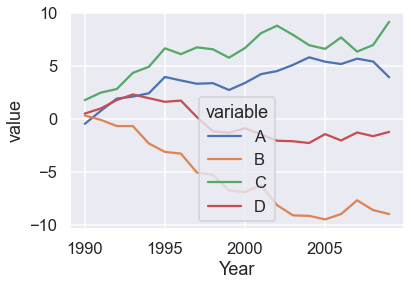

In [81]:
sns.lineplot(x='Year', y='value', hue='variable', 
             data=pd.melt(data_preproc, ['Year']))

In [ ]:
class_model_results(lgr, model_name ='logistic', X, dates, step, window_size, prediction_size, drop_first_k_days = 0): 